In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest
import statsmodels.stats.api as sms
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Nice to meet you, Data

In [2]:
# считываем данные
users_test = pd.read_csv('users_test.csv', sep=';')
users_c1   = pd.read_csv('users_control_1.csv', sep=';')
users_c2   = pd.read_csv('users_control_2.csv', sep=';')

transactions_test = pd.read_csv('transactions_test.csv', sep=';')
transactions_c1   = pd.read_csv('transactions_control_1.csv', sep=';')
transactions_c2   = pd.read_csv('transactions_control_2.csv', sep=';')

In [3]:
# посмотрим структуру датасетов о пользователях на примере тестовой группы
users_test.head(1)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0


In [4]:
# проверим, каждая ли строка в датасетах о пользователях содержит уникальный uid  
print('users_test:', all(users_test.uid.value_counts() == 1))
print('users_c1:', all(users_c1.uid.value_counts() == 1))
print('users_c2:', all(users_c2.uid.value_counts() == 1))

users_test: True
users_c1: True
users_c2: True


Как видим, в каждом датасете о пользователях нет повторяющихся uid, значит, датасеты о пользователях это такие таблицы, где каждая строка - это уникальный пользователь приложения, что следовало из названий таблиц. Но тем не менее, это стоило проверить :)

In [5]:
# посмотрим структуру датасетов о транзакциях пользователей на примере тестовой группы
transactions_test.head(1)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium


In [6]:
# проверим, каждая ли строка в датасетах о транзакицях пользователей содержит уникальный uid 
print('transactions_test:', all(transactions_test.uid.value_counts() == 1))
print('transactions_c1:', all(transactions_c1.uid.value_counts() == 1))
print('transactions_c2:', all(transactions_c2.uid.value_counts() == 1))

transactions_test: False
transactions_c1: False
transactions_c2: False


Названия таблиц не наврали и здесь! Действительно, строка в датасетах о транзакциях пользователей содержит информацию о той или иной совершённой транзакции пользователя приложения.

## How big is it?

In [7]:
# посмотрим на размерность датасетов
users_test_rows, users_test_columns = users_test.shape
users_c1_rows, users_c1_columns = users_c1.shape
users_c2_rows, users_c2_columns = users_c2.shape

transactions_test_rows, transactions_test_columns = transactions_test.shape
transactions_c1_rows, transactions_c1_columns = transactions_c1.shape
transactions_c2_rows, transactions_c2_columns = transactions_c2.shape

print(f'Датасет о пользователях тестовой группы содержит {users_test_rows} строк \
и {users_test_columns} столбцов')
print(f'Датасет о пользователях первой контрольной группы содержит {users_c1_rows} строк \
и {users_c1_columns} столбцов')
print(f'Датасет о пользователях второй контрольной группы содержит {users_c2_rows} строк \
и {users_c2_columns} столбцов\n')

print(f'Датасет о транзакциях пользователей из тестовой группы \
содержит {transactions_test_rows} строк и {transactions_test_columns} столбцов')
print(f'Датасет о транзакциях пользователей из первой контрольной группы \
содержит {transactions_c1_rows} строк и {transactions_c1_columns} столбцов')
print(f'Датасет о транзакциях пользователей из второй контрольной группы \
содержит {transactions_c2_rows} строк и {transactions_c2_columns} столбцов')

Датасет о пользователях тестовой группы содержит 4308 строк и 13 столбцов
Датасет о пользователях первой контрольной группы содержит 4340 строк и 13 столбцов
Датасет о пользователях второй контрольной группы содержит 4264 строк и 13 столбцов

Датасет о транзакциях пользователей из тестовой группы содержит 273 строк и 8 столбцов
Датасет о транзакциях пользователей из первой контрольной группы содержит 1007 строк и 8 столбцов
Датасет о транзакциях пользователей из второй контрольной группы содержит 328 строк и 8 столбцов


На первый взгляд, кажется интересным то, что датасет о транзакциях первой контрольной группы содержит в 3-4 раза больше строк, чем другие группы. Это в первую группу попали такие активные пользователи (что может говорить о плохой работе системы сплитования)? Или здесь что-то не так с данными?.. Будем разбираться!

## Attention! Missing data

In [8]:
# посмотрим количество пропущенных значений в трёх датасетах о пользователях 
null_summary_users = users_test \
                        .isna() \
                        .sum() \
                        .to_frame() \
                        .reset_index() \
                        .rename(columns={'index': 'column', 0: 'users_test'}) \
                     .merge(users_c1
                        .isna()
                        .sum()
                        .to_frame()
                        .reset_index()
                        .rename(columns={'index': 'column', 0: 'users_c1'}) , on='column') \
                     .merge(users_c2
                        .isna()
                        .sum()
                        .to_frame()
                        .reset_index()
                        .rename(columns={'index': 'column', 0: 'users_c2'}) , on='column')

null_summary_users

,column,users_test,users_c1,users_c2
0,uid,0,0,0
1,age,0,0,0
2,attraction_coeff,0,0,0
3,coins,4259,4280,4203
4,country,0,0,0
5,visit_days,1330,1324,1364
6,gender,0,0,0
7,age_filter_start,0,0,0
8,age_filter_end,0,0,0
9,views_count,0,0,0


In [9]:
# посмотрим количество пропущенных значений в трёх датасетах о транзакциях пользователей 
null_summary_transactions = transactions_test \
                                .isna() \
                                .sum() \
                                .to_frame() \
                                .reset_index() \
                                .rename(columns={'index': 'column', 0: 'transactions_test'}) \
                            .merge(transactions_c1
                                .isna()
                                .sum()
                                .to_frame()
                                .reset_index()
                                .rename(columns={'index': 'column', 0: 'transactions_c1'}) , on='column') \
                            .merge(transactions_c2
                                .isna()
                                .sum()
                                .to_frame()
                                .reset_index()
                                .rename(columns={'index': 'column', 0: 'transactions_c2'}) , on='column')

null_summary_transactions

,column,transactions_test,transactions_c1,transactions_c2
0,uid,0,630,0
1,country,0,630,0
2,joined_at,0,0,0
3,paid_at,0,0,0
4,revenue,0,630,0
5,payment_id,0,630,0
6,from_page,0,630,0
7,product_type,0,630,0


Оказывается, датасет о транзакциях первой контрольной группы содержит очень много строк с пустыми значениями по всем стоблцам, за исключением joined_at и paid_at. Скорее всего, это баг. Теперь понятно, почему в данном датасете относительно много строк.

## Did pandas get it right?

In [10]:
# посмотрим, правильно ли считались типы данных в трёх датасетах о пользователях
dtypes_summary_users = users_test \
                        .dtypes \
                        .to_frame() \
                        .reset_index() \
                        .rename(columns={'index': 'column', 0: 'users_test'}) \
                       .merge(users_c1
                        .dtypes
                        .to_frame()
                        .reset_index()
                        .rename(columns={'index': 'column', 0: 'users_c1'}) , on='column') \
                       .merge(users_c2
                        .dtypes
                        .to_frame()
                        .reset_index()
                        .rename(columns={'index': 'column', 0: 'users_c2'}) , on='column')

dtypes_summary_users

,column,users_test,users_c1,users_c2
0,uid,int64,int64,int64
1,age,int64,int64,int64
2,attraction_coeff,int64,int64,int64
3,coins,float64,float64,float64
4,country,object,object,object
5,visit_days,object,object,object
6,gender,int64,int64,int64
7,age_filter_start,int64,int64,int64
8,age_filter_end,int64,int64,int64
9,views_count,int64,int64,int64


Стоит отметить, что бинарная переменная gender считалась как int, а другие бинарные переменные was_premium и is_premium считались как float - это не страшно. В целом, данные считались правильно.

In [11]:
# посмотрим, правильно ли считались типы данных в трёх датасетах о транзакциях пользователей
dtypes_summary_transactions = transactions_test \
                                .dtypes \
                                .to_frame() \
                                .reset_index() \
                                .rename(columns={'index': 'column', 0: 'transactions_test'}) \
                              .merge(transactions_c1
                                .dtypes
                                .to_frame()
                                .reset_index()
                                .rename(columns={'index': 'column', 0: 'transactions_c1'}) , on='column') \
                              .merge(transactions_c2
                                .dtypes
                                .to_frame()
                                .reset_index()
                                .rename(columns={'index': 'column', 0: 'transactions_c2'}) , on='column')

dtypes_summary_transactions

,column,transactions_test,transactions_c1,transactions_c2
0,uid,int64,float64,int64
1,country,object,object,object
2,joined_at,object,object,object
3,paid_at,object,object,object
4,revenue,int64,float64,int64
5,payment_id,int64,float64,int64
6,from_page,object,object,object
7,product_type,object,object,object


А вот здесь, к сожалению, пандас не считал правильно колонки с датами joined_at и paid_at (хотя, было бы странно, если бы он их считал правильно, ведь я не указывал parse_dates в pd.read_csv()). Не беда, исправим!

In [12]:
# приведем колонки с датами к нужному типу во всех датасетах
transactions_test['joined_at'] = pd.to_datetime(transactions_test.joined_at, format="%Y-%m-%d %H:%M:%S")
transactions_test['paid_at'] = pd.to_datetime(transactions_test.paid_at, format="%Y-%m-%d %H:%M:%S")

transactions_c1['joined_at'] = pd.to_datetime(transactions_c1.joined_at, format="%Y-%m-%d %H:%M:%S")
transactions_c1['paid_at'] = pd.to_datetime(transactions_c1.paid_at, format="%Y-%m-%d %H:%M:%S")

transactions_c2['joined_at'] = pd.to_datetime(transactions_c2.joined_at, format="%Y-%m-%d %H:%M:%S")
transactions_c2['paid_at'] = pd.to_datetime(transactions_c2.paid_at, format="%Y-%m-%d %H:%M:%S")

In [13]:
# проверим изменения
dtypes_summary_transactions = transactions_test \
                                .dtypes \
                                .to_frame() \
                                .reset_index() \
                                .rename(columns={'index': 'column', 0: 'transactions_test'}) \
                              .merge(transactions_c1
                                .dtypes
                                .to_frame()
                                .reset_index()
                                .rename(columns={'index': 'column', 0: 'transactions_c1'}) , on='column') \
                              .merge(transactions_c2
                                .dtypes
                                .to_frame()
                                .reset_index()
                                .rename(columns={'index': 'column', 0: 'transactions_c2'}) , on='column')

dtypes_summary_transactions

,column,transactions_test,transactions_c1,transactions_c2
0,uid,int64,float64,int64
1,country,object,object,object
2,joined_at,datetime64[ns],datetime64[ns],datetime64[ns]
3,paid_at,datetime64[ns],datetime64[ns],datetime64[ns]
4,revenue,int64,float64,int64
5,payment_id,int64,float64,int64
6,from_page,object,object,object
7,product_type,object,object,object


Отлично! Теперь все колонки имеют правильный тип данных и можно переходить к блоку описательной статистики.

## Descriptive Statistics

In [14]:
# посчитаем описательную статистику по трём переменным для каждой группы
stat_users = users_test[['age', 'gender', 'total_revenue']] \
                    .describe() \
                    .rename(columns={'age': 'age_test',
                                     'gender': 'gender_test',
                                     'total_revenue': 'revenue_test'}) \
             .merge(users_c1[['age', 'gender', 'total_revenue']] \
                    .describe() \
                    .rename(columns={'age': 'age_c1',
                                     'gender': 'gender_c1',
                                     'total_revenue': 'revenue_c1'}), left_index=True, right_index=True) \
             .merge(users_c2[['age', 'gender', 'total_revenue']] \
                    .describe() \
                    .rename(columns={'age': 'age_c2',
                                     'gender': 'gender_c2',
                                     'total_revenue': 'revenue_c2'}), left_index=True, right_index=True) \
             [['age_test', 'age_c1', 'age_c2', 
                  'gender_test', 'gender_c1', 'gender_c2', 
                  'revenue_test', 'revenue_c1', 'revenue_c2']]

stat_users

,age_test,age_c1,age_c2,gender_test,gender_c1,gender_c2,revenue_test,revenue_c1,revenue_c2
count,4308.000000,4340.000000,4264.000000,4308.000000,4340.000000,4264.000000,4308.000000,4340.000000,4264.000000
mean,31.889276,32.095392,32.046201,0.953110,0.958065,0.954268,534.080316,594.761982,450.384146
std,10.245287,10.257466,10.170721,0.211427,0.200465,0.208927,4371.682632,7987.922925,2859.242228
min,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,24.000000,25.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,30.000000,30.000000,30.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,38.000000,38.000000,38.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,99.000000,99.000000,99.000000,1.000000,1.000000,1.000000,129870.000000,486330.000000,81796.000000


* Как видно из описательной статистики, средний возраст для трёх групп примерно одинаковый и составляет приблизительно 32 года (медиана равна 30)
* На удивление, доля женщин в трёх выборках не превышает 4%
* ARPU для трёх выборок отличается - об этом подробнее в блоке A/B тестирвоания. Но уже судя по описательной статистики можно сделать вывод о ненормальности распределения нормированной выручки в силу большого стандратного отклонения (std) и сильных выбросов (max).

In [15]:
# посмотрим распределение по странам для трёх групп
country_users = users_test \
                    .country \
                    .value_counts(normalize=True) \
                    .to_frame() \
                    .mul(100) \
                    .reset_index() \
                    .rename(columns={'index': 'country', 'country': 'percentage_test'}) \
                .merge(users_c1 
                    .country 
                    .value_counts(normalize=True) 
                    .to_frame() 
                    .mul(100)
                    .reset_index() 
                    .rename(columns={'index': 'country', 'country': 'percentage_c1'}), on='country', how='outer') \
                .merge(users_c2 
                    .country 
                    .value_counts(normalize=True) 
                    .to_frame() 
                    .mul(100)
                    .reset_index() 
                    .rename(columns={'index': 'country', 'country': 'percentage_c2'}), on='country', how='outer') 

country_users.head()

,country,percentage_test,percentage_c1,percentage_c2
0,United States of America,33.658310,33.894009,34.849906
1,Argentina,9.192201,8.963134,9.310507
2,France,8.333333,8.525346,8.818011
3,Italy,7.497679,7.788018,6.871482
4,Spain,6.987001,7.880184,7.270169


Пользователи из США оказались наиболее многочисленной группой для всех трёх выборок (34-35% от общего числа пользователей в выборках). В целом, доля пользователей из представленных топ-5 стран для каждой выборки примерно одинакова (максимальная разница не превышает 1%).

In [16]:
print('Всего в трёх выборках представлены пользователи из', country_users.shape[0], 'стран.')

Всего в трёх выборках представлены пользователи из 72 стран.


In [17]:
# посмотрим случайные пять строк из списка стран
country_users.sample(5)

,country,percentage_test,percentage_c1,percentage_c2
40,Brazil,0.023213,NaN,NaN
14,Switzerland,0.812442,0.967742,0.820826
22,Morocco,0.069638,NaN,0.117261
57,Sweden,NaN,0.023041,NaN
65,Malaysia,NaN,NaN,0.023452


Как видим, не все страны одновременно присутствуют во всех трёх выборках, однако доля граждан из таких стран очень мала.

## Какой тип продукта приносит больше всего выручки?

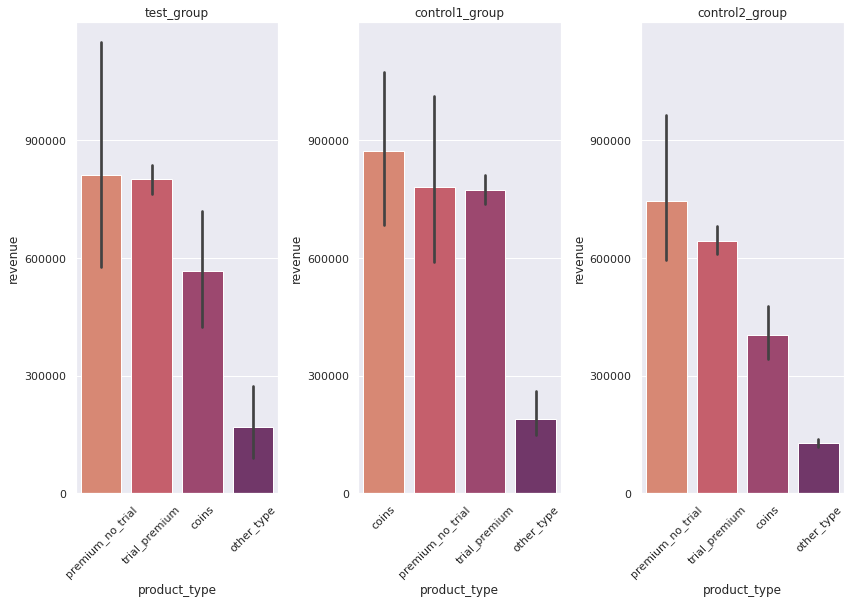

In [18]:
fig, ax = plt.subplots(1, 3, constrained_layout = True)

ticks = [0, 300000, 600000, 900000]

# строим график для тестовой группы
sns.barplot(data=transactions_test, 
            x='product_type', 
            y='revenue', 
            estimator=sum, 
            order=transactions_test
                  .groupby('product_type')
                  .agg({'revenue': 'sum'})
                  .sort_values('revenue', ascending=False)
                  .reset_index()
                  ['product_type'],
            palette="flare",
            ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('test_group')
ax[0].set_yticks(ticks)
ax[0].set_ylim(0, 1200000)

# строим график для первой контрольной группы
sns.barplot(data=transactions_c1, 
            x='product_type', 
            y='revenue', 
            estimator=sum, 
            order=transactions_c1
                  .groupby('product_type')
                  .agg({'revenue': 'sum'})
                  .sort_values('revenue', ascending=False)
                  .reset_index()
                  ['product_type'],
            palette="flare",
            ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('control1_group')
ax[1].set_yticks(ticks)
ax[1].set_ylim(0, 1200000)

# строим график для второй контрольной группы
sns.barplot(data=transactions_c2, 
            x='product_type', 
            y='revenue', 
            estimator=sum, 
            order=transactions_c2
                  .groupby('product_type')
                  .agg({'revenue': 'sum'})
                  .sort_values('revenue', ascending=False)
                  .reset_index()
                  ['product_type'],
            palette="flare",
            ax=ax[2])
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_title('control2_group')
ax[2].set_yticks(ticks)
ax[2].set_ylim(0, 1200000)

plt.show()

Судя по графикам, наибольшую выручку компании приносит подписка без пробного периода (premium_no_trial). С подпиской за внутреннюю валюту (coins) дела обстоят инетреснее: в первой контрольной группе этот тип продукта лидирует по суммарной выручке, а в тестовой и второй контрольной группе занимает лишь третью позицию. Вероятно, в данном случае не совсем корректно отработала система сплитования. Но об этом в следующем блоке!

In [19]:
# посчитаем долю пользователей с действующей подпиской для трёх групп
print('Доля пользователей с действующей премиум подпиской\n в первой контрольной группе =',
      round((users_c1.is_premium.count()/users_c1.uid.nunique())*100, 1),
      '%',
      '\n во второй контрольной группе =',
      round((users_c2.is_premium.count()/users_c2.uid.nunique())*100, 1),
      '%',
      '\n в тестовой группе =',
      round((users_test.is_premium.count()/users_test.uid.nunique())*100, 1),
      '%')

Доля пользователей с действующей премиум подпиской
 в первой контрольной группе = 4.4 % 
 во второй контрольной группе = 4.5 % 
 в тестовой группе = 3.6 %


## А что со временем? 

In [20]:
# посмотрим описательную статистику по датам оплат 
date_summary = transactions_test \
                        .describe(include='datetime') \
                        ['paid_at'] \
                        .to_frame() \
                        .rename(columns={'paid_at': 'paid_at_test'}) \
               .merge(transactions_c1 
                        .describe(include='datetime') 
                        ['paid_at'] 
                        .to_frame() 
                        .rename(columns={'paid_at': 'paid_at_c1'}),
                        left_index=True, right_index=True) \
               .merge(transactions_c2 
                        .describe(include='datetime') 
                        ['paid_at'] 
                        .to_frame() 
                        .rename(columns={'paid_at': 'paid_at_c2'}),
                        left_index=True, right_index=True)

date_summary

,paid_at_test,paid_at_c1,paid_at_c2
count,273,377,328
unique,258,335,309
top,2017-10-22 22:08:00,2017-10-16 02:08:00,2017-10-23 20:17:00
freq,4,5,3
first,2017-01-11 04:37:00,2016-12-14 16:16:00,2017-01-11 05:34:00
last,2017-12-11 22:06:00,2017-12-11 21:57:00,2017-12-11 23:28:00


Как мы видим, первая и последняя дата оплаты той или иной услуги отличается для трёх выборок, а поскольку мы хотим в дальнейшем сравнивать эти группы, то имеет смысл обозначить одинаковую фиксированную дату начала и завершения эксперимента.

In [21]:
print('Временем старта эксперимента будем считать', 
      date_summary.loc['first'].max(),  
      '\nВременем завершения -',
      date_summary.loc['last'].min())

Временем старта эксперимента будем считать 2017-01-11 05:34:00 
Временем завершения - 2017-12-11 21:57:00


## Something went wrong...

In [22]:
# проверим, правильно ли логируются даты
transactions_test \
    .query('joined_at > paid_at') \
    .head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins


Как видим, в некоторых строках с транзакциями пользователей неправильно записались даты регистрации/оплаты услуги. Возможно, в приложении произошёл какой-то кратковременный сбой, поскольку таких случаев не много.

In [23]:
print('В тестовых транзакциях аномальных строк с датами:', 
      transactions_test.query('joined_at > paid_at').shape[0],
      '\nВ контрольных (1) транзакциях аномальных строк с датами:', 
      transactions_c1.query('joined_at > paid_at').shape[0],
      '\nВ контрольных (2) транзакциях аномальных строк с датами:', 
      transactions_c2.query('joined_at > paid_at').shape[0])

В тестовых транзакциях аномальных строк с датами: 47 
В контрольных (1) транзакциях аномальных строк с датами: 55 
В контрольных (2) транзакциях аномальных строк с датами: 60


Ну что ж, отлично! С данными познакомились, теперь пора переходить к самому главному - анализу результатов эксперимента.

# Какие метрики использовать для нашего A/A/B эксперимента?

Я считаю, что наиболее правильно оценить успешность данного эксперимента нам помогут следующие три метрики: 
* **ARPU** (Average Revenue Per User), поскольку она нам покажет насколько все наши пользователи стали, в среднем, больше платить
* **ARPPU** (Average Revenue Per Paying User), поскольку проводится эксперимент, направленный непосредственно на наиболее активную часть пользователей, которая пользуется платными возможностями приложения, увеличивая тем самым выручку компании
* **Conversion rate** (конверсия в подписку), поскольку повышение стоиомости подписки (как и любого другого продукта) это достаточно рискованный шаг, который с большой вероятностью вызовет негативную реакцию у некоторых пользователей вплоть до "отписки". Поэтому необходимо очень внимательно смотреть, чтобы конверсия не падала.

# A/A, или проверка качества системы сплитования

Перед тем как непосредственно присутпить к А/Б тесту, нам необходимо убедиться в том, что наша система сплитования работает исправно - то есть средние значения интересующей нас метрики для двух контрольных групп должны быть примерно равны. Если этого не сделать, то может возникнуть такая ситуация, когда А/Б тест показал статистически значимые различия не из-за эффекта от эксперимента, а по причине поломки системы сплитования. Соответственно, могут быть сделаны неправильные выводы, которые приведут к потери прибыли компании.

## Подготовка данных

In [24]:
# считаем выручку с каждого платящего пользователя за нужный период
control_1_revenue_per_paying_user =  transactions_c1 \
                            .query('"2017-01-11 05:34:00" < paid_at < "2017-12-11 21:57:00"') \
                            .groupby('uid') \
                            .agg({'revenue': 'sum'})

control_2_revenue_per_paying_user =  transactions_c2 \
                            .query('"2017-01-11 05:34:00" < paid_at < "2017-12-11 21:57:00"') \
                            .groupby('uid') \
                            .agg({'revenue': 'sum'})

# сразу сделаем это и для тестовой группы
test_revenue_per_paying_user =  transactions_test \
                            .query('"2017-01-11 05:34:00" < paid_at < "2017-12-11 21:57:00"') \
                            .groupby('uid') \
                            .agg({'revenue': 'sum'})

In [25]:
# джойним с общими таблицами о всех пользователях
control_1 =  users_c1.merge(control_1_revenue_per_paying_user, on='uid', how='left')
control_2 =  users_c2.merge(control_2_revenue_per_paying_user, on='uid', how='left')

# сразу сделаем это и для тестовый группы 
test =  users_test.merge(test_revenue_per_paying_user, on='uid', how='left')

In [26]:
# после джойна у неплатящих пользователей в столбце revenue получился nan
# заменим его на 0, чтобы можно было проводить математические операции
control_1.revenue = control_1.revenue.fillna(0)
control_2.revenue = control_2.revenue.fillna(0)

test.revenue = test.revenue.fillna(0)

## Распределение нормированной выручки

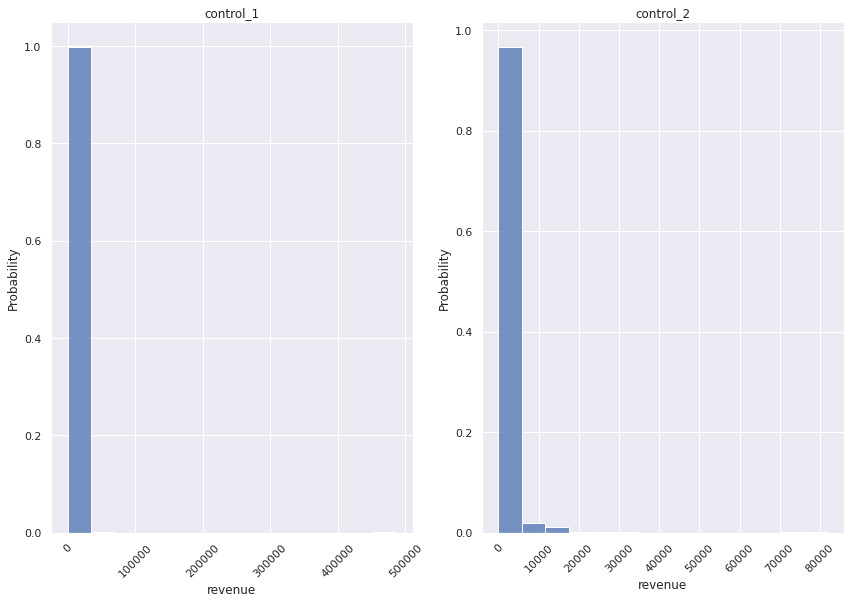

In [27]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

# строим гистограмму распределения для первой контрольной группы
sns.histplot(control_1.revenue, stat='probability', ax=ax[0])
ax[0].set_title('control_1')
ax[0].tick_params(axis='x', rotation=45)

# строим гистограмму распределения для второй контрольной группы
sns.histplot(control_2.revenue, stat='probability', ax=ax[1])
ax[1].set_title('control_2')
ax[1].tick_params(axis='x', rotation=45)

plt.show()

По графикам видно, что распределение нормированной выручки, как минимум, не является нормальным и сильно скошено вправо. Однако, большое количество неплатящих пользователей (иными словами, нулей на графике) не позволяет в силу масштаба увидеть и другие значения, чтобы более точно оценить распределения (на левом графике эта проблема наиболее острая), поэтому давайте еще построим графики только для платящих пользователей.

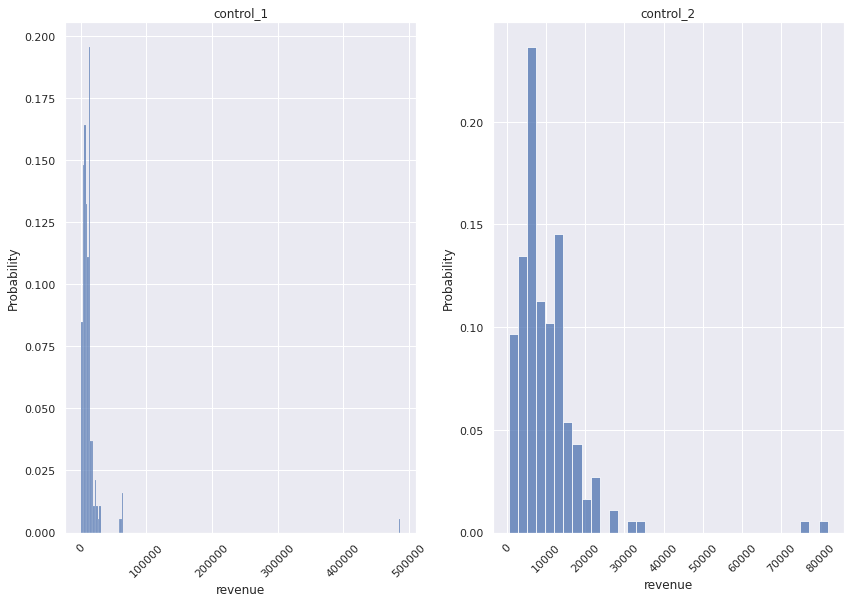

In [28]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

# строим гистограмму распределения для первой контрольной группы
sns.histplot(control_1.query('revenue > 0').revenue, stat='probability', ax=ax[0])
ax[0].set_title('control_1')
ax[0].tick_params(axis='x', rotation=45)

# строим гистограмму распределения для второй контрольной группы
sns.histplot(control_2.query('revenue > 0').revenue, stat='probability', ax=ax[1])
ax[1].set_title('control_2')
ax[1].tick_params(axis='x', rotation=45)

plt.show()

Действительно, эти графики уже намного более удобные для визуального анализа распределения. Видно, что распределение как первой контрольной группы, так и второй контрольной группы не является нормальным, оно асимметричное (скошено вправо). 

И хотя это еще не является поводом отказаться от использования Т-теста для сравнения средних, но вот наличие сильных выбросов как в первой, так и во второй выборке уже является весомым аргументом отказаться от критерия Стьюдента. Тест Манна-Уитни в данной ситуации также не является оптимальным решением, поскольку он достаточно плохо работает с большим количеством повторяющихся значений в выборке (в нашем случае это нули - неплатящие пользователи, на предыдущих графиках). По этой причине, для сравнения средних между двумя выборками будем использовать метод бутстрап, который не является таким требовательным к форме данных.

In [29]:
# функция для бутстрапа
def get_bootstrap(
                  data_column_1, # числовые значения первой выборки
                  data_column_2, # числовые значения второй выборки
                  statistic, # интересующая нас статистика
                  draw=False, # нарисовать распределение
                  boot_it = 1000, # количество бутстрэп-подвыборок
                  bootstrap_conf_level = 0.95 # уровень значимости
                  ):
    
    boot_data = []
    
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1 \
                    .sample(len(data_column_1), replace = True) \
                    .values
        
        samples_2 = data_column_2 \
                    .sample(len(data_column_1), replace = True) \
                    .values
        
        # считаем разницу статистик между двумя подвыборками и сохраняем в список
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(x = 0, 
                         loc = np.mean(boot_data), 
                         scale = np.std(boot_data))
    
    p_2 = stats.norm.cdf(x = 0, 
                         loc = -np.mean(boot_data), 
                         scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2

    # Визуализация
    if draw:
        _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('ggplot')
        plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Качество системы сплитования будем проверять с помощью многократных симуляций:
* Извлекаем две случайные подвыборки одного размера из первой и второй контрольной группы соответственно
* Используем бутстрап для оценки стат.значимости различий средних в двух выборках (Н0: средние двух выборок не различаются статистически значимо)
* Повторяем это n-ное количество раз, записывая каждый раз p-value
* Считаем количество ложноположительных случаев (когда Т-тест показал p-value < 0.05)
* Если доля ложноположительных случаев от общего числа симуляций получилась меньше уровня значимости (0.05), то делаем вывод, что наша система сплитования работает исправно. В противном случае, нужно искать причину поломки "сплитовалки".

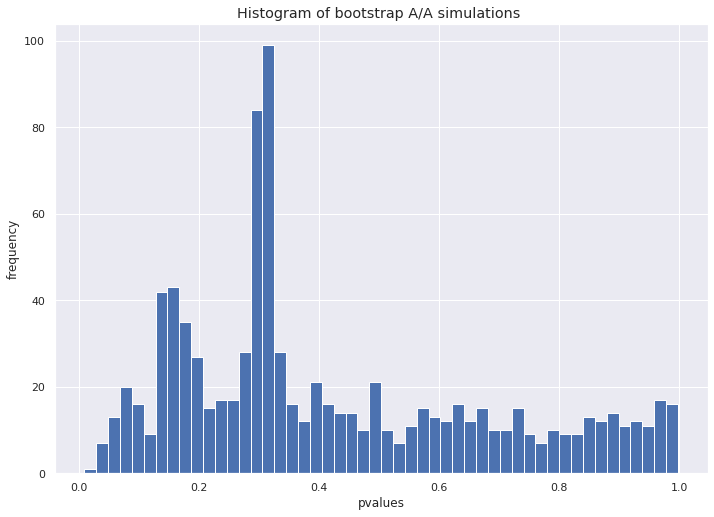

Бинго! Система сплитования работает исправно!


In [30]:
simulations = 1000 # количество симуляций
sample_size = 30  # размер подвыборки
results = []

# запускаем симуляции A/A теста
for i in tqdm(range(simulations)):
    sample1 = control_1.revenue.sample(sample_size, replace = False)
    sample2 = control_2.revenue.sample(sample_size, replace = False)
    results.append(get_bootstrap(sample1, sample2, statistic=np.mean)['p_value']) # сохраняем pvalue в список

plt.hist(results, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()

# проверяем, что количество ложноположительных случаев не превышает альфа
if (sum(np.array(results) <0.05) / simulations) < 0.05:
    print('Бинго! Система сплитования работает исправно!')
else:
    print('Упс, что-то пошло не так... Нужно проверить систему сплитования.')
    

Итак, по метрике revenue сплит прошёл успешно, теперь посморим всё ли хорошо и с конверсией в подписку.

In [31]:
# создаем бинарную перемнную для пользоваталей, где 1 - пользователь купил подписку, 0 - не купил
test['conversion'] = test['is_premium'].apply(lambda x: 1 if x == 1 else 0)
control_1['conversion'] = control_1['is_premium'].apply(lambda x: 1 if x == 1 else 0)
control_2['conversion'] = control_2['is_premium'].apply(lambda x: 1 if x == 1 else 0)

Для начала, проверим равенство дисперий между двумя контрольными группами (чтобы оценить возожность использования параметрических тестов). Н0: дисперсии между группами не различаются статистически значимо. 

In [32]:
# Запускаем тест Левена о равенстве дисперсий двух выборок
stats.levene(control_1.conversion, control_2.conversion)

LeveneResult(statistic=0.01551626073675317, pvalue=0.9008714163221571)

Как видим, мы не можем отвергнуть нулевую гипотезу в данном случае, что в купе с относительно большими выборками даёт нам право использовать параметрические тесты для оценки статистической значимости различий средних.

Качество системы сплитования, как и прежде, будем проверять с помощью многократных симуляций, однако в данном случае будем использовать z-test для сравнения средних двух выборок, поскольку для бинарных данных он дает более точные оценки, нежели t-test. Н0: средние двух выборок не различаются статистически значимо.

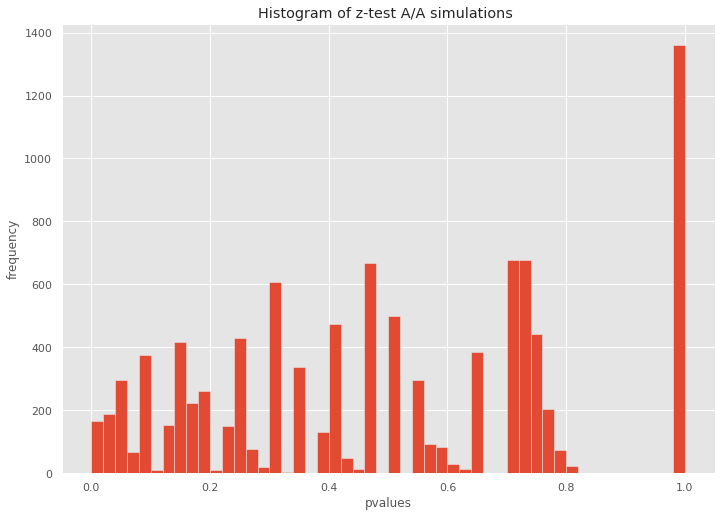

Бинго! Система сплитования работает исправно!


In [33]:
simulations = 10000 # количество симуляций
sample_size = 100  # размер подвыборки
results = []

# запускаем симуляции A/A теста
for i in tqdm(range(simulations)):
    sample1 = control_1.conversion.sample(sample_size, replace = False).values
    sample2 = control_2.conversion.sample(sample_size, replace = False).values
    results.append(ztest(sample1, sample2)[1]) # сохраняем pvalue в список

plt.hist(results, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of z-test A/A simulations ")
plt.show()

# проверяем, что количество ложноположительных случаев не превышает альфа
if (sum(np.array(results) <0.05) / simulations) < 0.05:
    print('Бинго! Система сплитования работает исправно!')
else:
    print('Упс, что-то пошло не так... Нужно проверить систему сплитования.')
    

Сплитование по конверсии также успешное, поэтому можем смело переходить к А/Б тестированию.

# A/B testing, or is our experiment worth it?

Проанализируем, как в ходе эксперимента повели себя три метрики (ARPU, ARPPU, Conversion rate), чтобы оценить стоит ли всё-таки повышать стоимость подписки для всех пользователей.

## ARPU

In [34]:
# объединяем две контрольные группы в одну
control= pd.concat([control_1, control_2])

In [35]:
print('Размер контрольной группы =', control.shape[0])
print('Размер тестовой группы =', test.shape[0])

Размер контрольной группы = 8604
Размер тестовой группы = 4308


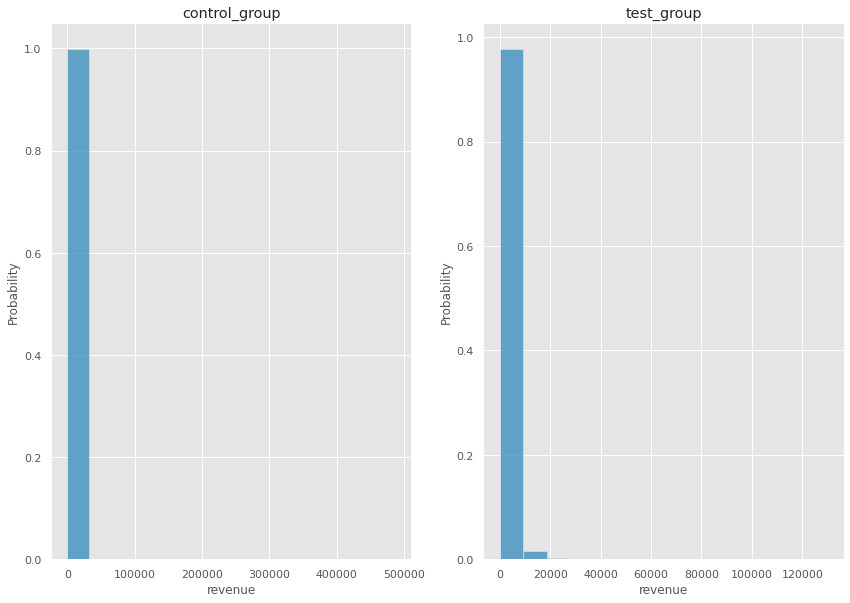

In [36]:
# посмотрим распределения
fig, ax = plt.subplots(1, 2, constrained_layout=True)

sns.histplot(control.revenue, stat='probability', ax=ax[0])
ax[0].set_title('control_group')

sns.histplot(test.revenue, stat='probability', ax=ax[1])
ax[1].set_title('test_group')

plt.show()

Опять же, наличие сильных выбросов в данном случае не позволяет нам использовать критерий Стьюдента для проверки гипотезы о статистической значимости различий средних в двух выборках, а большое количество повторяющихся значений - не позволяет нам использовать тест Манна-Уитни, поэтому будем использовать для этой цели бутстрап. Н0: средние двух выборок не различаются статистически значимо. Мы же, в свою очередь, хотим отклонить нулевую гипотезу и принять альтернативную о том, что ARPU в следствие эксперимента статистически значимо увеличился.

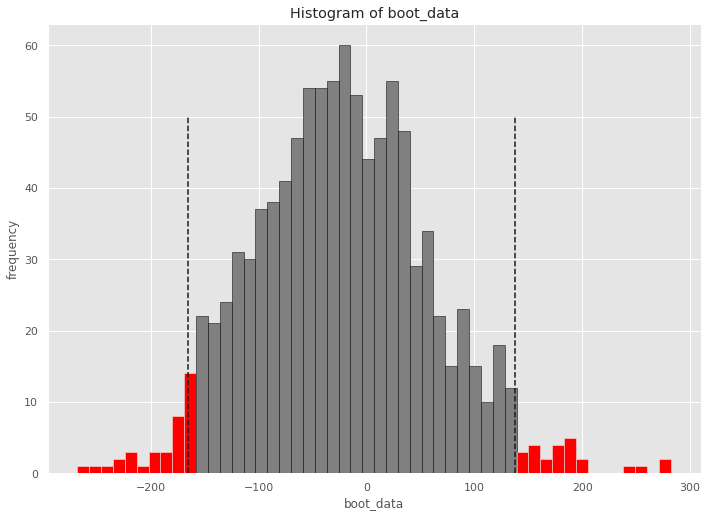

In [37]:
# применяем функцию бутстрап
bs = get_bootstrap(control.revenue, test.revenue, statistic=np.mean, draw=True)

In [38]:
bs['quants']

,0
0.025,-165.736704
0.975,138.221359


In [39]:
bs['p_value']

0.783378811902303

Как видим, ноль попал в 95% доверительный интервал, поэтому, к сожалению, в данной ситуации мы не можем отвергнуть нулевую гипотезу об отсутсвии стат.значимого различия ARPU между тестом и контролем.

## ARPPU

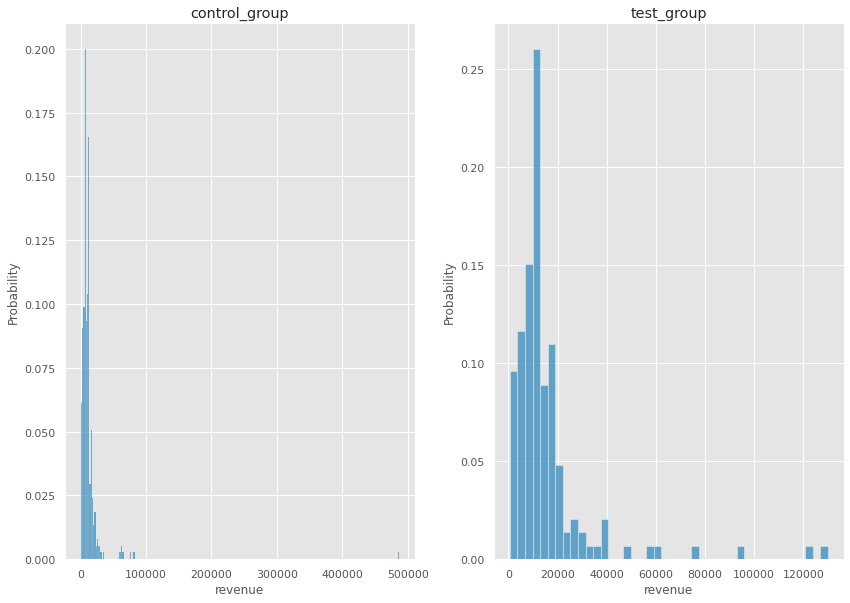

In [40]:
# посмотрим распределения вырчуки для платящих пользователей
fig, ax = plt.subplots(1, 2, constrained_layout=True)

sns.histplot(control.query('revenue > 0').revenue, stat='probability', ax=ax[0])
ax[0].set_title('control_group')

sns.histplot(test.query('revenue > 0').revenue, stat='probability', ax=ax[1])
ax[1].set_title('test_group')

plt.show()

Здесь ситуация схожая, как и в случае со всеми пользователями: наличие сильных выбросов не позволяет нам использовать критерий Стьюдента для проверки гипотезы о статистической значимости различий средних в двух выборках, поэтому будем использовать для этой цели бутстрап. Н0: средние двух выборок не различаются статистически значимо. Мы же, в свою очередь, хотим отклонить нулевую гипотезу и принять альтернативную о том, что ARPPU в следствие эксперимента статистически значимо увеличился.

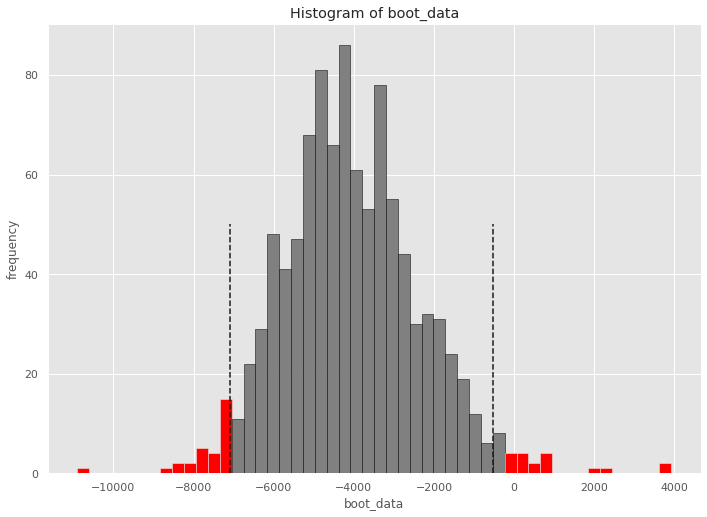

In [41]:
# применяем функцию бутстрап
bs = get_bootstrap(control.query('revenue > 0').revenue, 
                   test.query('revenue > 0').revenue, 
                   statistic=np.mean, 
                   draw=True)

In [42]:
bs['quants']

,0
0.025,-7084.383800
0.975,-520.143867


In [43]:
bs['p_value']

0.016709222328047914

Как видим, ноль не попал в 95% доверительный интервал, что говорит о статистической значимости различий средних в двух выборках (p-value, очевидно, также < 0.05).

In [44]:
# изменение ARPPU между тестом и контролем
((test.query('revenue > 0').revenue.mean()
  -
  control.query('revenue > 0').revenue.mean())
  /
  control.query('revenue > 0').revenue.mean())*100

34.11515318075691

Итак, хорошая новость! В тестовой группе ARPPU получился примерно на 34% выше, чем в контрольной группе (при этом, результат статистически значимый).

## CR

Для начала, проверим равенство дисперий между контрольной и тестовой группой. Н0: дисперсии между группами не различаются статистически значимо.

In [45]:
# запускаем тест Левена
stats.levene(test.conversion, control.conversion)

LeveneResult(statistic=4.66670984613786, pvalue=0.030771130488176052)

Тест Левена показал, что на 5% уровне значимости дисперсии между группами статистически значимо различаются. Выборки у нас относительно большие, переменная - бинарная, поэтому в данной ситуации для оценки статистической значимости различий средних в двух выборках будем использовать z-test с поправкой на неравную дисперсию в выборках. Н0: средние двух выборок не различаются статистически значимо. В данной ситуации мы не хотим отвергать нулевую гипотезу о равенсте конверсий между тестом и контролем, поскольку всё же есть вероятность того, что повышение стоимости подписки приведёт к потере лояльности пользователей и снижению конверсии.

In [46]:
# запускаем z-test
cm = sms.CompareMeans(sms.DescrStatsW(test.conversion), sms.DescrStatsW(control.conversion))
z, pval = cm.ztest_ind(usevar='unequal')
print(f'z: {z}, p-value: {pval}')

z: -2.2300010000756667, p-value: 0.02574737648441344


Опасения подтвердились, и на 5% уровне значимости мы отвергаем нулевую гипотезу и принимаем альтернативную о том, что конверсия в подписку статистически значимо ралзичается между тестом и контролем.

In [47]:
# изменение конверсии в подписку между тестом и контролем
((test.conversion.mean()-control.conversion.mean())/control.conversion.mean())*100

-18.12985010582049

Итак, повышение стомости подписки снизило конверсию приблизительно на 18% (результат статистически значимый).

# Выкатываем обновление на всех пользователей?

Исходя из проведенного выше анализа, я бы не сказал, что эксперимент прошёл успешно - мы не получили стат. значимого увеличения ARPU, ARPPU показал статистически значимый прирост (+34%), но при этом на 18% упала конверсия в подписку.

Однако, что если разные группы пользователей реагируют на повышение стоимости подписки по-разному? Например, молодые люди отнеслиль к этому спокойно, а люди в возрасте, наоборот, отреагировали очень плохо, отказавшись от продления уже более дорогой платной подписки, и тогда лучше не выкатывать обновление на более возрастную группу пользователей, чтобы не потерять прибыль и клиентов? Для прояснения таких моментов есть смысл разбить всех пользователей на несколько групп (по тому или иному признаку) и посмотреть одинаково ли они отреагировали на изменение стоимости подписки (выводы будем делать на основании ARPPU и конверсии - для нас важно, чтобы стат. значимо вырос ARPPU и при это не просела конверсия статистически значимо).

Для проведения данного анализа поочередно разобём пользователей на группы по следующим показателям: 
* **возраст** (гипотеза заключается в том, что молодые люди склонны к новым знакомствам больше, чем люди в возрасте, и как следствие, повышение стоимости подписки для первых не имеет такой же критический вес, как для вторых)
* **коэффициент привлекательности** (гипотеза заключается в том, что люди с низким коэффициентом привлекательности получают мало лайков, и как следствие, редко находят себе пару. А поскольку платная подписка в дейтинговом приложении зачастую означает возможность ставить бесконечное количество лайков, видеть лайкнувших тебя людей и чаще попадать в рекомендации, то повышение стоимости платной подписки для таких пользователей не столько критично, как для пользователей с высоким коэффициентом привлекательности, которые смогут и без платной подписки быстро найти себе пару)
* **страна** (гипотеза заключается в том, что для пользователей США повышение стоимости подписки не так критично, как для остальных пользователей, в силу развитой экономики и высокой оплаты труда)
* Было бы также интересно разделить пользователей по **полу**, но поскольку из описательной статистики мы выяснили, что доля женщин в группах не превышает 5% (а в тестовой группе вообще всего 2 женщины, которые пользуются платными возможностями приложения), то делать какие-либо статистические выводы на таких данных было бы преступлением...

Итак, начнём!

In [48]:
# объединяем контрольную и тестовую группу в один датасет 
combined_df = pd.concat([control
                        [['uid', 'revenue', 'age', 'attraction_coeff', 'country', 'conversion']]
                        .assign(group = 'control'),
                        test
                        [['uid', 'revenue', 'age', 'attraction_coeff', 'country', 'conversion']]
                        .assign(group = 'test')])

combined_df.sample(5)

,uid,revenue,age,attraction_coeff,country,conversion,group
1191,891783804,0.0,31,750,Chile,0,test
1618,891249720,0.0,32,314,United Kingdom (Great Britain),0,control
3245,891995145,27404.0,39,547,United States of America,0,test
3739,892005012,0.0,22,0,Portugal,0,control
3123,891367356,0.0,49,250,United States of America,0,control


## The younger, the better?

In [49]:
# поделим пользователей на 3 группы по возрасту
combined_df['age_group'] = pd.cut(combined_df.age, 
                                 bins=[18, 27, 35, 99], # границы разделения
                                 labels=['junior', 'middle', 'senior'])

In [50]:
# посмотрим на размер получившихся групп
combined_df.age_group.value_counts()

junior    4612
senior    4105
middle    3653
Name: age_group, dtype: int64

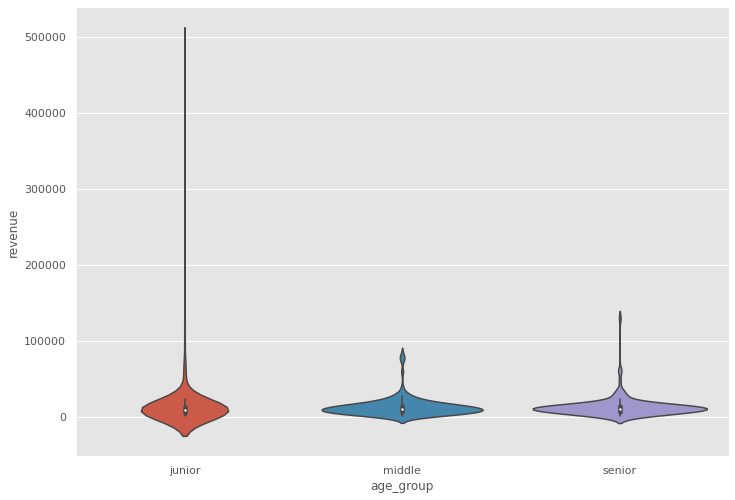

In [51]:
# построим скрипичный график для трёх возрастных групп (paying users only)
sns.violinplot(data=combined_df.query('revenue > 0'), x='age_group', y='revenue');

Из графика видно, что распределения нормированной выручки для трёх возрастных групп (paying users only) не являются нормальными (скошены вправо) и имеют выбросы (в случае с наиболее молодой группой пользователей эта проблема наиболее острая). И как результат, мы не можем использовать в данном случае ANOVA для оценки статистической значимости различий средних между тремя выборками. В таком случае, прибегнем к его "непараметрическому аналогу" - критерию Краскелла-Уоллиса. Н0: средние ранги между тремя выборками статистически значимо не различаются. В данном случае, мы хотим отвергнуть нулевую гипотезу и принять альтернативную о том, что как минимум в двух группах средние ранги различаются стат.значимо, чтобы понять стоит ли дальше "копать" в этом направлении.

In [52]:
pg.kruskal(data=combined_df.query('revenue > 0'), dv='revenue', between='age_group')

,Source,ddof1,H,p-unc
Kruskal,age_group,2,7.144617,0.028091


Отлично! p-value < 0.05, значит, всё же есть смысл рассмотреть эти группы более детально.

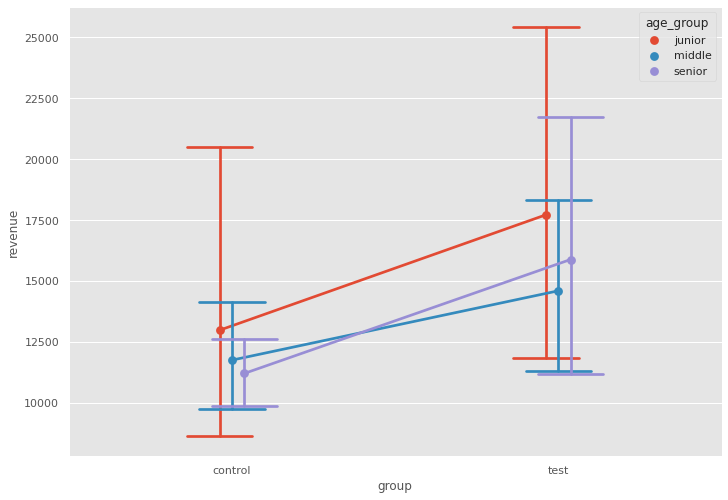

In [53]:
# отобразим средние с доверительными интервалами в разрезе двух групп (возраст и тест/контроль)
sns.pointplot(x='group', y='revenue', hue='age_group', data=combined_df.query('revenue > 0'), capsize=.2, dodge=True);

В силу достаточно проблемных распределений (выбросы), доверительные интервалы для средних значений получились достаточно широкими и поэтому очень сложно по графику сделать вывод о стат.значимости различий средних между выборками. Без парных сравнений средних здесь не обойтись!

Для парных сравнений средних значений нормированной выручки между разными группами (paying users only) будем использовать непараметрический тест Манна-Уитни (в силу выбросов и небольших выборок). Н0: средние ранги между двумя группами не различаются статистиечски значимо. Мы же хотим отклонять нулевую гипотезу (особенно в рамках одной возрастной группы между тестом и контролем), чтобы убедиться, что та или иная возрастная группа стала приносить, в среднем, нам больше выручки.

In [54]:
# конкатенируем два фактора в один столбец
combined_df['combination_of_factors'] = combined_df['group'] + '\\' + combined_df['age_group'].astype('string')

In [55]:
# проводим парные тесты Манна-Уитни с попарвкой p-value Хольма
pg.pairwise_ttests(data=combined_df.query('revenue > 0'), 
                   dv='revenue', 
                   between='combination_of_factors', 
                   parametric=False, 
                   padjust='holm')

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,combination_of_factors,control\junior,control\middle,False,False,6580.5,two-sided,0.050162,0.501618,holm,0.038484
1,combination_of_factors,control\junior,control\senior,False,False,6625.5,two-sided,0.004039,0.048462,holm,0.057467
2,combination_of_factors,control\junior,test\junior,False,False,1849.0,two-sided,0.000131,0.001972,holm,-0.126388
3,combination_of_factors,control\junior,test\middle,False,False,2570.5,two-sided,0.000372,0.005210,holm,-0.045410
4,combination_of_factors,control\junior,test\senior,False,False,2661.0,two-sided,0.001699,0.022090,holm,-0.079599
5,combination_of_factors,control\middle,control\senior,False,False,5570.5,two-sided,0.508903,1.000000,holm,0.056635
6,combination_of_factors,control\middle,test\junior,False,False,1661.5,two-sided,0.039008,0.429086,holm,-0.384237
7,combination_of_factors,control\middle,test\middle,False,False,2232.5,two-sided,0.076512,0.575524,holm,-0.235412
8,combination_of_factors,control\middle,test\senior,False,False,2256.5,two-sided,0.132391,0.794343,holm,-0.279889
9,combination_of_factors,control\senior,test\junior,False,False,1876.0,two-sided,0.071941,0.575524,holm,-0.485891


Статистически значимые различия получились для следующих пар: 

1)control\junior vs control\senior\
**2)control\junior vs test\junior**\
3)control\junior vs test\middle\
4)control\junior vs test\senior	

Иными словами, статистически значимый эффект от эксперимента (по выручке) наблюдается только для самой молодой группы пользователей приложения. И это, с одной стороны, хорошая новость. Но что если у данной группы пользователей параллельно "просели" стат.значимо и другие важные метрики (например, конверсия)? Тогда уже не всё так хорошо. Давайте проверим! 

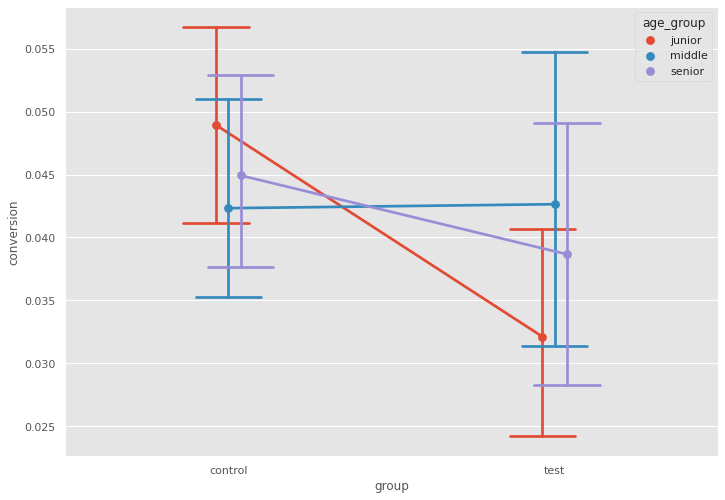

In [56]:
# отобразим среднюю конверсию с доверительными интервалами в разрезе двух групп (возраст и тест/контроль)
sns.pointplot(x='group', y='conversion', hue='age_group', data=combined_df, capsize=.2, dodge=True);

В данном случае по графику уже можно сделать какие-то предположения о стат.значимости различий средних, и, к сожалению, эти предположения нас не радуют - веротянее всего, именно у молодой группы пользователей стат.значимо снизилась конверсия в подписку. Убедиться в этом нам поможет z-test. Н0: средние значения между группами не различаются статистически значимо. 

In [57]:
# проверим равенство дисперсий между группами перед проведением z-теста 
# Н0: дисперсии между группами не различаются стат.значимо
pg.homoscedasticity(data=combined_df, dv='conversion', group='age_group')

,W,pval,equal_var
levene,0.02185,0.978387,True


Тест Левена показал, что мы не можем отвергнуть нулвеую гипотезу о равенстве дисперсий между группами. Отлично! Тогда можем смело запускать парные z-тесты (сделаем поправку Бонферонни, чтобы избежать проблемы множественных сравнений). 

In [58]:
# выводим результаты z-тестов в датафрейм
ztests_age = pd.DataFrame({'A': ['control\\junior', 'control\\middle', 'control\\senior'],
                           'B': ['test\\junior', 'test\\middle', 'test\\senior'],
                           'p_alpha_Bonferonni': [0.05/3, 0.05/3, 0.05/3], # поправка Бонферонни
                           'p_value': [ztest(
                                        combined_df
                                       .query('group == "control" and age_group == "junior"').conversion, 
                                        combined_df
                                       .query('group == "test" and age_group == "junior"').conversion)[1],
                                       ztest(
                                        combined_df
                                       .query('group == "control" and age_group == "middle"').conversion, 
                                        combined_df
                                       .query('group == "test" and age_group == "middle"').conversion)[1],
                                       ztest(
                                        combined_df
                                       .query('group == "control" and age_group == "senior"').conversion, 
                                        combined_df
                                       .query('group == "test" and age_group == "senior"').conversion)[1]]})
ztests_age

,A,B,p_alpha_Bonferonni,p_value
0,control\junior,test\junior,0.016667,0.008282
1,control\middle,test\middle,0.016667,0.964301
2,control\senior,test\senior,0.016667,0.352360


Итак, действительно, только у молодой группы пользователей стат.значимо снизилась конверсия в покупку, что делает вывод относительно повышение стоимости подписки для данной группы совесм не тривиальным. С одной стороны, эта группа пользователей, в среднем, стала больше давать выручки компании после повышения стоимости подписки (в отличии от других возрастных групп), но с другой стороны, этот эффект наблюдается, в том числе, за счёт значимого сокращения конверсии (что вполне логично, ведь у молодой группы пользователей денежный вопрос стоит достаточно остро). Исходя из всего вышесказанного, я считаю, что в долгосрочной перспективе такой шаг себя не окупит, поэтому попробуем проанализировать данные в другом разрезе (коэффициент привлекательности пользователя).

## High attraction is good, or is it?

In [59]:
# посчитаем 33 и 66 перцентиль распределения attraction_coeff (paying users)
combined_df.query('revenue > 0').attraction_coeff.quantile(q=[0.33, 0.66])

0.33    216.6
0.66    410.2
Name: attraction_coeff, dtype: float64

In [60]:
# делим пользователей на 3 группы с помощью перцентилей
combined_df['attr_coef_group'] = pd.cut(combined_df.attraction_coeff, 
                                 bins=[-1, 217, 410, 1000], 
                                 labels=['low', 'medium', 'high'])

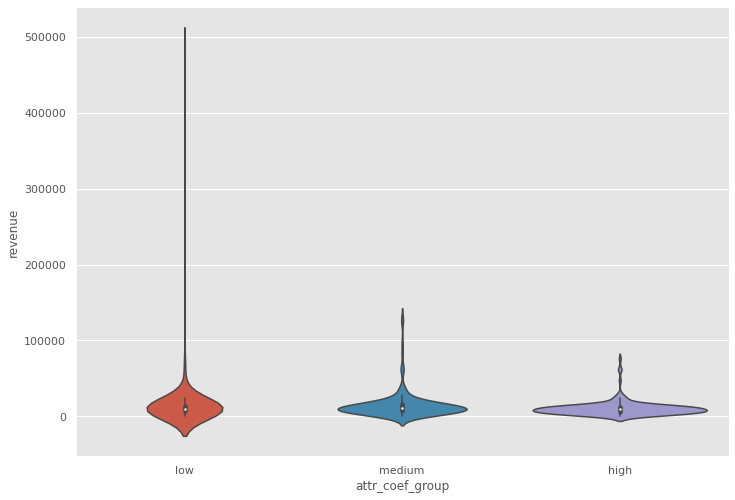

In [61]:
# строим скрипичный график нормированной выручки для трёх групп (paying users)
sns.violinplot(data=combined_df.query('revenue > 0'), x='attr_coef_group', y='revenue');

Из графика опять же видно, что распределения нормированной выручки для трёх групп (paying users only) не являются нормальными (скошены вправо) и имеют выбросы. И как результат, мы не можем использовать в данном случае ANOVA для оценки статистической значимости различий средних между тремя выборками. В таком случае, прибегнем к его "непараметрическому аналогу" - критерию Краскелла-Уоллиса. Н0: средние ранги между тремя выборками статистически значимо не различаются. В данном случае, мы хотим отвергнуть нулевую гипотезу и принять альтернативную о том, что как минимум в двух группах средние ранги отличаются стат.значимо, чтобы понять стоит ли дальше "копать" в этом направлении.

In [62]:
pg.kruskal(data=combined_df.query('revenue > 0'), dv='revenue', between='attr_coef_group')

,Source,ddof1,H,p-unc
Kruskal,attr_coef_group,2,9.077097,0.010689


Тест показал p-value < 0.05, значит, всё же есть смысл рассмотреть эти группы более детально.

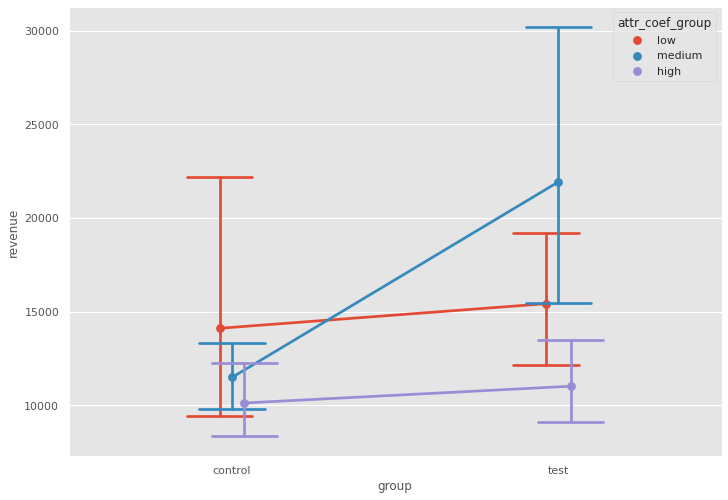

In [63]:
# отобразим средние с доверительными интервалами в разрезе двух групп (коэф. привлекательности и тест/контроль)
sns.pointplot(x='group', 
              y='revenue', 
              hue='attr_coef_group', 
              data=combined_df.query('revenue > 0'), 
              capsize=.2, 
              dodge=True);

Судя по графику, есть разница в ARPPU между тестом и контролем для пользователей со средним коэффициентом привлекательности. Для более точного ответа о статистической значимости различий средних прибегнем к парным непараметрическим тестам Манна-Уитни (в силу выбросов и небольших выборок). Н0: средние ранги между двумя группами не различаются статистиечски значимо. Мы же хотим отклонять нулевую гипотезу (особенно в рамках одной группы (attr_coef_group) между тестом и контролем), чтобы убедиться, что та или иная группа стала приносить, в среднем, нам больше выручки.

In [64]:
# конкатенируем два фактора в один столбец
combined_df['combination_of_factors_2'] = combined_df['group'] + '\\' + combined_df['attr_coef_group'].astype('string')

In [65]:
# проводим парные тесты Манна-Уитни с попарвкой p-value Хольма
pg.pairwise_ttests(data=combined_df.query('revenue > 0'), 
                   dv='revenue', 
                   between='combination_of_factors_2', 
                   parametric=False, 
                   padjust='holm')

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,combination_of_factors_2,control\high,control\low,False,False,7157.0,two-sided,0.148264,0.741320,holm,-0.126817
1,combination_of_factors_2,control\high,control\medium,False,False,6358.0,two-sided,0.030626,0.245009,holm,-0.131920
2,combination_of_factors_2,control\high,test\high,False,False,2684.0,two-sided,0.053877,0.323261,holm,-0.091793
3,combination_of_factors_2,control\high,test\low,False,False,1635.5,two-sided,0.000081,0.001129,holm,-0.483107
4,combination_of_factors_2,control\high,test\medium,False,False,1718.5,two-sided,0.000009,0.000130,holm,-0.689425
5,combination_of_factors_2,control\low,control\medium,False,False,7467.5,two-sided,0.485271,1.000000,holm,0.083263
6,combination_of_factors_2,control\low,test\high,False,False,3198.5,two-sided,0.496501,1.000000,holm,0.084951
7,combination_of_factors_2,control\low,test\low,False,False,1973.5,two-sided,0.002589,0.028478,holm,-0.034903
8,combination_of_factors_2,control\low,test\medium,False,False,2117.0,two-sided,0.000678,0.008818,holm,-0.198678
9,combination_of_factors_2,control\medium,test\high,False,False,3074.5,two-sided,0.607815,1.000000,holm,0.048833


Статистически значимые различия получились для следующих пар: 

1)control\high vs test\low\
2)control\high vs test\medium\
**3)control\low vs test\low**\
4)control\low vs test\medium\
**5)control\medium vs test\medium**

Таким образом, статистически значимый эффект от эксперимента (по выручке) наблюдается как для пользователей с низким коэффициентом привлекательности, так и для пользователей со средним коэффициентом привлекательности. И здесь, опять же, для полной картины необходимо посмотреть и на конверсию в подписку.  

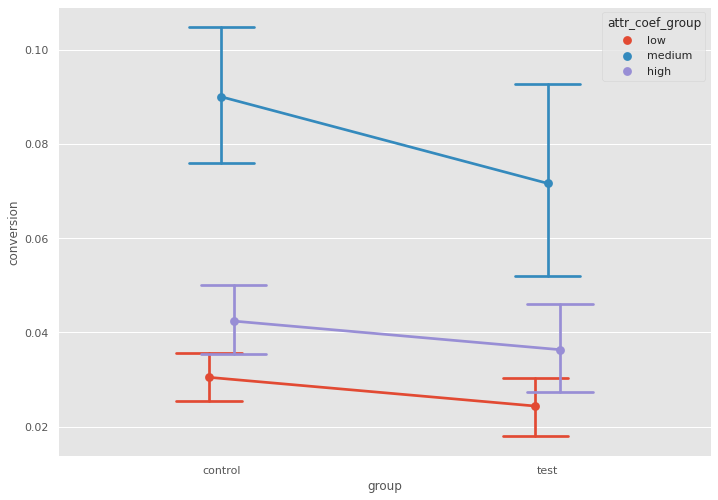

In [66]:
# отобразим среднюю конверсию с доверительными интервалами в разрезе двух групп (коэф. привлек. и тест/контроль)
sns.pointplot(x='group', y='conversion', hue='attr_coef_group', data=combined_df, capsize=.2, dodge=True);

По графику хорошо видно, что средняя конверсия в подписку, в целом, различается для трёх групп, разделённых по коэффициенту привлекательности. Однако, нам более важно и интересно посмотреть на стат.значимость различий средних в разрезе тест/контроль для одной и той же группы, чтобы оценить возможность безболезненного повышения стоимости подписки для тех групп, у которых стат.значимо вырос ARPPU. Для этого воспользуемся z-тестом. Н0: средние значения между группами не различаются статистически значимо.

In [67]:
# проверим равенство дисперсий между группами перед проведением z-теста
# Н0: дисперсии между группами не различаются стат.значимо
pg.homoscedasticity(data=combined_df, dv='conversion', group='attr_coef_group')

,W,pval,equal_var
levene,61.673979,2.200333e-27,False


Тест Левена показал, что дисперсии между группами различаются стат.значимо, значит, при проведении парных z-тестов сделаем на это поправку (как и поправку Бонферонни для корректировки уровня значимости, чтобы избежать проблемы парных сравнений).

In [68]:
# запускаем z-test для оценки стат.значимости различий средних между control/low и test/low групп
cm = sms.CompareMeans(sms.DescrStatsW(combined_df.query('group == "control" and attr_coef_group == "low"').conversion), 
                      sms.DescrStatsW(combined_df.query('group == "test" and attr_coef_group == "low"').conversion))
z, pval = cm.ztest_ind(usevar='unequal')
print(f'z: {z}, p-value: {pval}')

z: 1.4104268244625706, p-value: 0.15841368937698153


In [69]:
# запускаем z-test для оценки стат.значимости различий средних между control/medium и test/medium групп
cm = sms.CompareMeans(sms.DescrStatsW(combined_df.query('group == "control" and attr_coef_group == "medium"').conversion), 
                      sms.DescrStatsW(combined_df.query('group == "test" and attr_coef_group == "medium"').conversion))
z, pval = cm.ztest_ind(usevar='unequal')
print(f'z: {z}, p-value: {pval}')

z: 1.495288226966067, p-value: 0.13483923629849986


In [70]:
# запускаем z-test для оценки стат.значимости различий средних между control/high и test/high групп
cm = sms.CompareMeans(sms.DescrStatsW(combined_df.query('group == "control" and attr_coef_group == "high"').conversion), 
                      sms.DescrStatsW(combined_df.query('group == "test" and attr_coef_group == "high"').conversion))
z, pval = cm.ztest_ind(usevar='unequal')
print(f'z: {z}, p-value: {pval}')

z: 1.0118655809670964, p-value: 0.31160232816359257


Итак, в трёх z-тестах p-value > 0.05/3. Значит, мы не можем в каждом из них отвергнуть нулевую гипотезу о том, что средние не различаются стат.значимо. Отличная новость! Получается, что у групп "low" и "medium" в тестовой выборке наблюдается статистически значимый положительный эффект (по выручке) от эксперимента и при этом разница в конверсии в подписку между тестом и контролем для этих групп не является статистически значимой! Иными словами, эти группы пользователей отнеслись к повышению стоимости подписки спокойно, и на них можно в полной мере выкатывать обновление.

Проанализируем данные еще в одном разрезе - резидент / не резидент США.

## USA! USA! USA!

In [71]:
# разделим пользоваталей на резидентов США и не резидентов США
combined_df['US_residency'] = combined_df['country'] \
                                .apply(lambda x: 
                                'US_resident' if x == "United States of America" else 'non_US_resident')

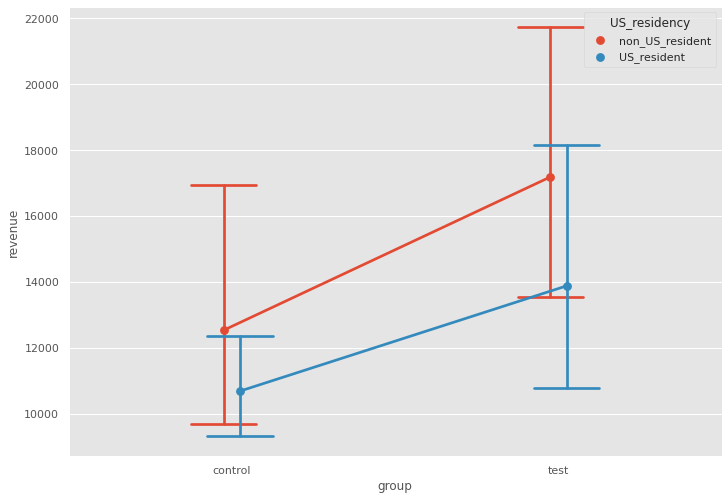

In [72]:
# отобразим средние с доверительными интервалами в разрезе двух групп (рез. США/не США и тест/контроль)
sns.pointplot(x='group', 
              y='revenue', 
              hue='US_residency', 
              data=combined_df.query('revenue > 0'), 
              capsize=.2, 
              dodge=True);

Исходя из получившегося графика, можно предположить, что есть разница в ARPPU между тестом и контролем для пользователей как для резидентов США и не США. Более точно ответив на этот вопрос с теста Манна-Уитни (в силу сильных выбросов). Н0: средние ранги между двумя группами не различаются статистиечски значимо.

In [73]:
# проводим два непараметрических теста
mwu_country = pd.DataFrame({'A': ['control\\US_resident', 'control\\non_US_resident'],
                            'B': ['test\\US_resident', 'test\\non_US_resident'],
                            'p_alpha_Bonferonni': [0.05/2, 0.05/2], # поправка Бонферонни
                            'p_value': [stats.mannwhitneyu(
                                combined_df
                               .query('revenue > 0 and group == "control" and US_residency == "US_resident"').revenue, 
                                combined_df
                               .query('revenue > 0 and group == "test" and US_residency == "US_resident"').revenue)[1],
                                        stats.mannwhitneyu(
                                combined_df
                               .query('revenue > 0 and group == "control" and US_residency == "non_US_resident"').revenue, 
                                combined_df
                               .query('revenue > 0 and group == "test" and US_residency == "non_US_resident"').revenue)[1]]})
mwu_country

,A,B,p_alpha_Bonferonni,p_value
0,control\US_resident,test\US_resident,0.025,0.007255
1,control\non_US_resident,test\non_US_resident,0.025,0.000178


Как видим, для обеих групп пользователей наблюдается статистически значимый эффект от эксперимента. Теперь необходимо посмотреть на конверсию в покупку для этих групп между тестом и контролем.

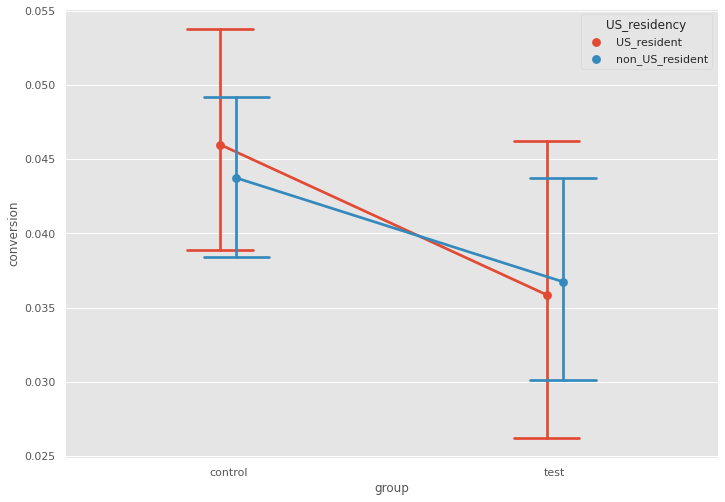

In [74]:
# отобразим среднюю конверсию с доверительными интервалами в разрезе двух групп (рез/не рез США. и тест/контроль)
sns.pointplot(x='group', y='conversion', hue='US_residency', data=combined_df, capsize=.2, dodge=True);

По графику видно, что доверительные интервалы конверсии тестовой группы включают в себя средние значения конверсии контрольной группы (в разрезе резидентов/не резидентов США). Поэтому, скорее всего, разница в конверсии в подписку для этих групп между тестом и контролем не статистически значима. Проверим это с помощью z-теста. Н0: средние значения между группами не различаются статистически значимо.

In [75]:
# проверим равенство дисперсий между группами перед проведением z-теста
# Н0: дисперсии между группами не различаются стат.значимо
pg.homoscedasticity(data=combined_df, dv='conversion', group='US_residency')

,W,pval,equal_var
levene,0.117187,0.732111,True


Итак, мы не можем отвергнуть нулевую гипотезу о равенсте дисперсий между группами. Теперь смело запускаем z-тесты!

In [76]:
# выводим результаты z-тестов в датафрейм
ztests_us = pd.DataFrame({'A': ['control\\US_resident', 'control\\non_US_resident'],
                          'B': ['test\\US_resident', 'test\\non_US_resident'],
                          'p_alpha_Bonferonni': [0.05/2, 0.05/2], # поправка Бонферонни
                          'p_value': [ztest(
                                combined_df
                               .query('group == "control" and US_residency == "US_resident"').conversion, 
                                combined_df
                               .query('group == "test" and US_residency == "US_resident"').conversion)[1],
                                        ztest(
                                combined_df
                               .query('group == "control" and US_residency == "non_US_resident"').conversion, 
                                combined_df
                               .query('group == "test" and US_residency == "non_US_resident"').conversion)[1]]})
ztests_us

,A,B,p_alpha_Bonferonni,p_value
0,control\US_resident,test\US_resident,0.025,0.117891
1,control\non_US_resident,test\non_US_resident,0.025,0.125731


Как видно из таблицы, мы не можем отвергнуть нулевую гипотезу об отсутсвии стат.значимого различия конверсии между тестом и контролем как для резидентов США, так и для не резидентов США. Таким образом, нет смысла разделять всех пользователей по этому критерию, поскольку они примерно одинаково отреагировали на повышение стомости подписки.

## Что в итоге делаем?

Поскольку повышение стоимости подписки это достаточно рискованный шаг, который может привести к снижению лояльности пользователей и даже к их потере, то необходимо очень чётко понимать, на какие группы пользователей можно выкатывать такое обновление с минимальными для компании потерями, а для каких групп лучше повременить с рискованной задумкой.

В ходе анализа было выявлено, что ARPPU следюущих групп пользователей статистически значимо вырос в ответ на повышение стоиомсти подписки:
* Пользователи от 18 до 27 лет
* Пользователи с коэффициентом привлекательности от 0 до 410.

Однако, у пользователей от 18 до 27 лет было обнаружено статистически значимое падение конверсии в подписку вследствие эксперимента, что в долгосрочной перспективе может принести убытки компании. 

Таким образом, чтобы повысить прибыль компании, не потеряв при этом много лояльных пользователей, **выкатываем обновление только для пользователей с коэффициентом привлекательности от 0 до 410**.